# 0-Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import numpy as np

import time

# 1- Import data

In [2]:
torch.backends.cudnn.deterministic = True
LABEL = data.LabelField(dtype = torch.float)
TEXT = data.Field(tokenize = 'spacy')
fields = [(None, None),(None, None), (None, None), (None, None),(None, None),(None, None), ('label', LABEL),(None, None),(None, None), (None, None),(None, None),('text',TEXT)]
train_data = data.TabularDataset(path = 'data/data_filtered2_balanced_all.csv', format = 'csv', fields = fields, skip_header = True)
print(f'Number of data examples: {len(train_data)}')

train_data, test_data = train_data.split(0.8)
train_data, valid_data = train_data.split(0.8)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of data examples: 98474
Number of training examples: 63023
Number of validation examples: 15756
Number of testing examples: 19695


# 2- Build vocabulary

In [3]:
MAX_VOCAB_SIZE = 95_000 #most common 25000 words
LABEL.build_vocab(train_data)
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

print(f"Most common words: {TEXT.vocab.freqs.most_common(20)}") #most common words
print(f"Vocabulary:{TEXT.vocab.itos[:10]}") #to see vocabulary
print(f"Labels: {LABEL.vocab.stoi}") #to see labels

Unique tokens in TEXT vocabulary: 91228
Unique tokens in LABEL vocabulary: 2
Most common words: [('.', 294685), (',', 233462), ('the', 217346), ('I', 198168), ('and', 153803), ('a', 144700), ('to', 130367), (' ', 123300), ('it', 108553), ('of', 105862), ('is', 91858), ('in', 67807), ('this', 66422), ('for', 64756), ('that', 58667), ('was', 44925), ('my', 44275), ('you', 44077), ('with', 42918), ('have', 42547)]
Vocabulary:['<unk>', '<pad>', '.', ',', 'the', 'I', 'and', 'a', 'to', ' ']
Labels: defaultdict(<function _default_unk_index at 0x00000227F36B57B8>, {'0': 0, '1': 1})


# 3- Build iterators

In [4]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x:x.text, #sort by s attribute (quote) #Ideally, you want to use a sort key as the BucketIterator
    sort_within_batch=True,
    batch_size=BATCH_SIZE,
    device=device)

# 4- Build the model

In [10]:
#1- Define the model

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 1, output_dim) #-->biderectional
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))#-->dropout(1)
        
        output, (hidden, cell) = self.rnn(embedded)
        
        return self.dropout(self.fc(hidden.squeeze(0)))
    
#2- Create an instance of the RNN class

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
OUTPUT_DIM = 1
DROPOUT = 0.4

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            DROPOUT)

#3-  Trainable parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters') #much more than in version 1


C:\Users\arrij\Anaconda3\New folder\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


The model has 4,622,301 trainable parameters


# 5 - Train the model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


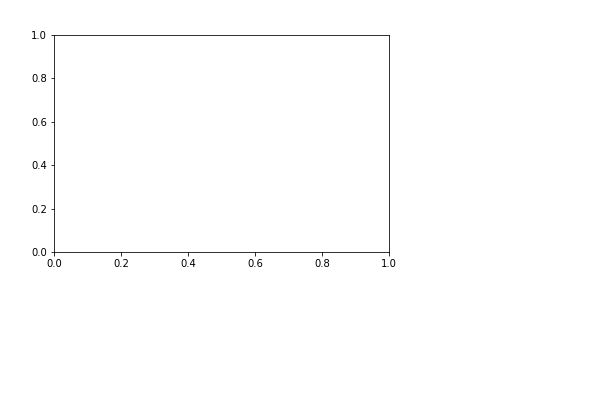

<IPython.core.display.Javascript object>


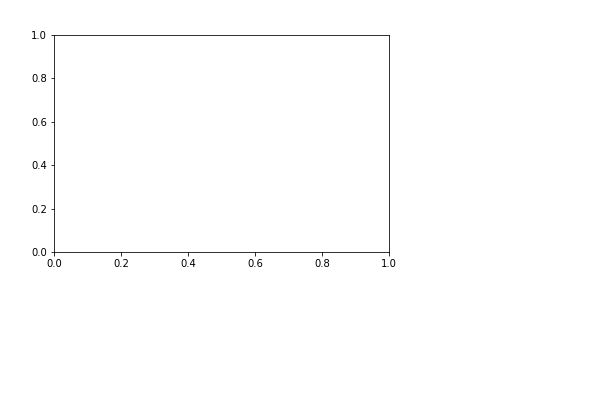

KeyboardInterrupt: 

In [11]:
#0- Set up the plotting figure
%matplotlib inline
%config InlineBackend.figure_format ='svg'
%load_ext autoreload
%autoreload 2
%matplotlib notebook
#1- Set up the optimizer
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-3)

#2- Sigmoid and boundary cross entropy
criterion = nn.BCEWithLogitsLoss()

#3- Move them to GPU
model = model.to(device)
criterion = criterion.to(device)

#4- Accuracy function
def binary_accuracy(preds, y): #Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    rounded_preds = torch.round(torch.sigmoid(preds)) #round predictions to the closest integer
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

#5- Train function
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text = batch.text
        
        predictions = model(text).squeeze(1) #doing the forward call
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#6- Evaluate function
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            
            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#7- Epoch running time function
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#8- Train the model
N_EPOCHS = 200

best_valid_loss = float('inf')
cont = -1
train_loss_vec = np.zeros(N_EPOCHS)
valid_loss_vec = np.zeros(N_EPOCHS)
train_acc_vec = np.zeros(N_EPOCHS)
valid_acc_vec = np.zeros(N_EPOCHS)

best_valid_loss = float('inf')

fig1 = plt1.figure()
ax1 = fig1.add_subplot(111)
fig1.show()
fig1.canvas.draw()

fig2 = plt2.figure()
ax2 = fig2.add_subplot(111)
fig2.show()
fig2.canvas.draw()
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    cont = cont + 1
    train_loss_vec[cont]=train_loss
    valid_loss_vec[cont]=valid_loss
    train_acc_vec[cont]=train_acc
    valid_acc_vec[cont]=valid_acc
    
    ax1.clear()
    ax1.plot(range(1,epoch+2),train_acc_vec[0:cont+1],'-o', label=r'Training accuracy') 
    ax1.plot(range(1,epoch+2),valid_acc_vec[0:cont+1],'-o', label=r'Validation accuracy')
    fig1.legend(loc='best')
    fig1.canvas.draw()
    
    ax2.clear()
    ax2.plot(range(1,epoch+2),train_loss_vec[0:cont+1],'-o', label=r'Training loss') 
    ax2.plot(range(1,epoch+2),valid_loss_vec[0:cont+1],'-o', label=r'Validation loss')
    fig2.legend(loc='best')
    fig2.canvas.draw()

# 6- Final results

In [9]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.566 | Test Acc: 71.70%


# 7- User input

In [22]:
import spacy
nlp = spacy.load('en')

#1- Load model
model.load_state_dict(torch.load('tut2-model.pt'))

#2- Sentiment prediction function
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

#3- Test some sentences
sentence1="The food was very good. I will buy again for sure. Completely recommend it"
out1 = predict_sentiment(model, sentence1) #should be close to 0
print(f'Sentence: {sentence1} | Estimation: {out1}')

sentence2="Don't buy this. It was disgusting and the flavour was weird. I don't recommend it at all"
out2=predict_sentiment(model,sentence2) #should be close to 1
print(f'Sentence: {sentence2} | Estimation: {out2}')

Sentence: The food was very good. I will buy again for sure. Completely recommend it | Estimation: 0.38031142950057983
Sentence: Don't buy this. It was disgusting and the flavour was weird. I don't recommend it at all | Estimation: 0.3685385584831238
